# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.


## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.


### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):


In [233]:
! wget - -no-check-certificate \
    https: // storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    - O ./cats_and_dogs_filtered.zip


'wget' is not recognized as an internal or external command,
operable program or batch file.


In [234]:
! unzip - qo cats_and_dogs_filtered.zip


unzip:  cannot find either qo or qo.zip.


This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.


In [235]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats - type f | wc - l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs - type f | wc - l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats - type f | wc - l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs - type f | wc - l)


'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.
'wc' is not recognized as an internal or external command,
operable program or batch file.


### Loading the data

Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.


In [236]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image  # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
    transforms.RandomRotation(20, resample=Image.BILINEAR),
    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
    normalize,
])

validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize,
])

train_dataset = torchvision.datasets.ImageFolder(
    root='./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder(
    root='./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))


C:\Users\gbert\AppData\Local\Temp\ipykernel_7184\17233886.py:20: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  transforms.RandomRotation(20, resample=Image.BILINEAR),


Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):


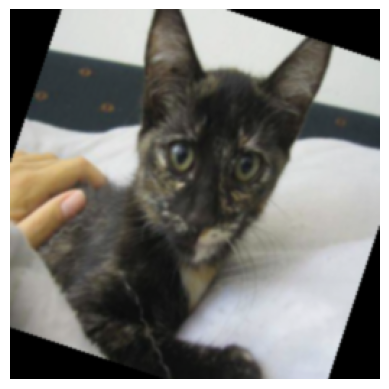

In [237]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100  # change dpi to make plots bigger


def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')


show_normalized_image(train_dataset[12][0])


### Creating the model


Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

- Convolutional layers (at least two)
- Batch Norm
- Non-linearity
- Pooling layers
- A residual connection similar to that of Res-Net
- A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).


In [238]:
from torch import nn


class CNN_Solution(torch.nn.Module):

    def __init__(self):
        super().__init__()
        # TODO
        self.residual = nn.Identity()

        self.conv_layers = nn.Sequential(

            # Conv2D outpdimut along image input dim W: int((W + 2*p - d*(k - 1) - 1)/s) + 1 
            nn.Conv2d(
                in_channels=3, #color image RGB
                out_channels=32, #hope a large num of filters may learn more about input
                kernel_size = (3,3), 
                padding = 1), 
            # num_features tells BatchNorm how many features are in the output of the function above it;
            #  channels (the output of conv2d prior feeding in to it) are equivalent to features but channels 
            # is more commonly used when referring to image data sets as the original image has a certain number of colored channels. 
            nn.BatchNorm2d(num_features=32),
            # MaxPool output along dim w: same as above as this is sort of a filter/kernel too taking max instead of inner prod sums;
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), #max-pooling and monotonely increasing non-linearities commute. This means that MaxPool(Relu(x)) = Relu(MaxPool(x)) for any input (not the case for avg pooling)
            # num_features tells BatchNorm how many features are in the output of the function above it;
            #  channels (the output of conv2d prior feeding in to it) are equivalent to features but channels 
            # is more commonly used when referring to image data sets as the original image has a certain number of colored channels. 
            
            nn.Conv2d(
                in_channels=32,
                out_channels=8,
                kernel_size=(5,5),
                stride=1,
                padding=0),
            nn.BatchNorm2d(num_features=8),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=(3,3),
                stride=1,
                padding=0),
            nn.BatchNorm2d(num_features=16),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),

            nn.Flatten()
        )

        # Linear input dim: for 1d in_features dim outputs out_features; for 2d input accept
        # (N batch * in_features dim)-> (N batch * in_features dim * out_features dim);
        # for 3d take in (N batch * C_rows * each with in_features dim) -> (N * C_rows * out_features)
        # can flatten this shit (pytorch does use matmul for it) so for 3d (N*C_rows, in_features) becomes N*C rows of vecs with dim in_features, etc.
        self.fc_layers = nn.Sequential(
            nn.Linear(1536, 120), #nn.Linear(input_size, n_hidden),
            #nn.BatchNorm1d(120),
            #nn.ReLU(),
            #nn.Linear(120, 64),
            #nn.BatchNorm1d(64),
            #nn.ReLU(),
            #nn.Linear(64, 3),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # TODO
        # ResNet residual: Add the residual before the block to its output

        residual1 = x    #Save input as residual
        print(x.size())
        x = self.conv_layers(x)
        print(x.size())
        
        x += residual1 #add input to output of conv_layers
        residual2 = x  #save output of conv_layers as residual
        
        x = self.fc_layers(x)
        print(x.size())
        
        x += residual2 #add output of conv_layers to output of fc_layers
        
        x = self.Global_Avg_Pool(x) #Global average pooling instead of fully connected.
        x = x.view(-1, 16*4*4)
        x = torch.nn.functional.log_softmax(self.end(x),dim=1)
        
        return x


In [239]:
# print out the exact model architecture
model = CNN_Solution()
print("Model Architecture:")
print(model)

# pass in dummy examples to see if the model is built correctly

input_size = (128, 3, 224, 224)
sample = torch.rand(size = input_size)
out = model.forward(sample)
print(f"* Input tensor size: {input_size}, \n* Output tensor size: {out.size()}")

Model Architecture:
CNN_Solution(
  (residual): Identity()
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1536, out_features=120, bias=True)
    (1): LogSoftm

RuntimeError: The size of tensor a (10816) must match the size of tensor b (224) at non-singleton dimension 3

### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.


In [ ]:
from tqdm.notebook import tqdm


def get_loss_and_correct(model, batch, criterion, device):
    # Implement forward pass and loss calculation for one batch.
    # Remember to move the batch to device.
    #
    # Return a tuple:
    # - loss for the batch (Tensor)
    # - number of correctly classified examples in the batch (Tensor)
    pass


def step(loss, optimizer):
    # Implement backward pass and update.
    # TODO
    pass


N_EPOCHS = 5
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, num_workers=4)
model = CNN_Solution()

criterion = None  # TODO

optimizer = None  # TODO

model.train()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
    total_train_loss = 0.0
    total_train_correct = 0.0
    total_validation_loss = 0.0
    total_validation_correct = 0.0

    model.train()

    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct.item()

    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(
                model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct.item()

    mean_train_loss = total_train_loss / len(train_dataset)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataset)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    validation_losses.append(mean_validation_loss)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss,
                     'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})


Now that the model is trained, we want to visualize the training and validation losses and accuracies:


In [ ]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()


Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
`put your answer here`


### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.


In [ ]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.


### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.


In [ ]:
image = validation_dataset[10][0]
show_normalized_image(image)


Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```


In [ ]:
import math


def plot_intermediate_output(result, title):
    """ Plots the intermediate output of shape
        N_FILTERS x H x W
    """
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

# TODO:
# pick a few intermediate representations from your network and plot them using
# the provided function.


What can you say about those filters? What features are they focusing on?

Anwer: `Your answer here`
